#### Alexa Andrews and Jeffrey Mulderink  
#### Group name: aa_jm_knn   
#### Project title: Improved kNN classifier


Our data set was looking to predict whether a person would default on their credit card payment based on gender, age, marital status and education level, as well as the original amount of credit. For each month Sept-April, it there are attributes for their history of payment (whether they paid on time or how far delayed their payment is), the amount of their last payment, and the amount of their bill. The class label we are trying to predict is whether they will default on their payment the next month.

Since our table has around 30 thousand instances and kNN is rather slow, we used a random subset of our data in our tests.  
We thought we should remove the first column of our table, which was ID, because the order these instances happen to be in shouldn't be of relevance to whether they will make their next payment, and it was not included on the list of attributes for the dataset. Initially we had ID and oddly enough removing it led to lower recall, precision, and F-measure for different k values. Without removing ID, it was often amongst the top attributes in the top subset. From visual inspection of our data, it did not appear that the class label was sorted in any way. 
We found that zeroR and kNN with our found optimal k, attribute subset, and weights generally performed the best.



In [1]:
import utils
import numpy as np
import math
import copy
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

header, table = utils.open_csv_with_header("default_of_credit_card_clients.csv")

np.random.shuffle(table)
table = table[:1000]

header = header[1:]
table = utils.remove_column(table, 0)

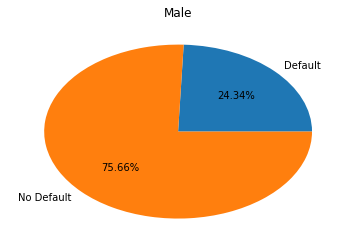

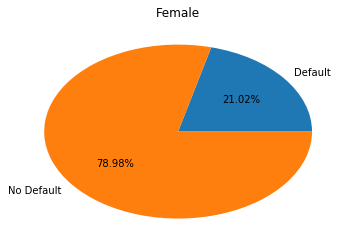

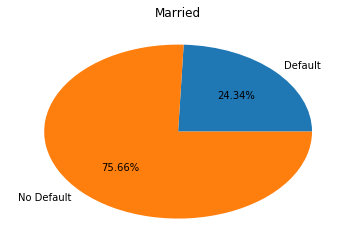

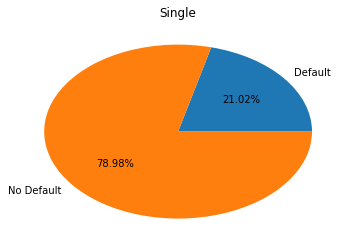

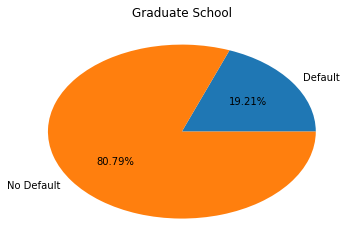

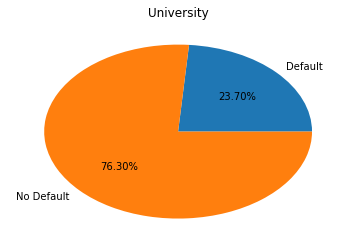

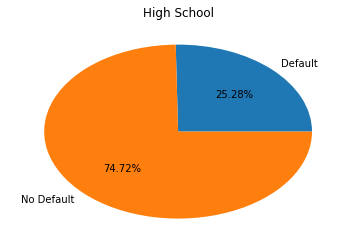

In [2]:
header, table1 = utils.open_csv_with_header("default_of_credit_card_clients.csv")

def pie_charts(table1):
    gender_freq = [0,0,0,0]
    marriage_freq = [0,0,0,0]
    education_freq = [0,0,0,0,0,0]
    labels = ["Default","No Default"]
    for row in table1:
        if row[2]==1:#male
            if row[24]==1:
                gender_freq[1]+=1
            else:
                gender_freq[0]+=1
        if row[2]==2:#female
            if row[24]==1:
                gender_freq[3]+=1
            else:
                gender_freq[2]+=1
        if row[2]==1:#married
            if row[24]==1:
                marriage_freq[1]+=1
            else:
                marriage_freq[0]+=1
        if row[2]==2:#single
            if row[24]==1:
                marriage_freq[3]+=1
            else:
                marriage_freq[2]+=1
        if row[3]==1:#grad
            if row[24]==1:
                education_freq[1]+=1
            else:
                education_freq[0]+=1
        if row[3]==2:#uni
            if row[24]==1:
                education_freq[3]+=1
            else:
                education_freq[2]+=1
        if row[3]==3:#high school
            if row[24]==1:
                education_freq[5]+=1
            else:
                education_freq[4]+=1
    #male defaultvs nondefault
    plt.figure()
    plt.pie([gender_freq[1],gender_freq[0]],labels=labels,autopct="%1.2f%%")
    plt.title("Male")
    plt.savefig("pie_chart_male_defaulting.png")        

    plt.figure()
    plt.pie([gender_freq[3],gender_freq[2]],labels=labels,autopct="%1.2f%%")
    plt.title("Female")
    plt.savefig("pie_chart_female_defaulting.png")   

    plt.figure()
    plt.pie([marriage_freq[1],marriage_freq[0]],labels=labels,autopct="%1.2f%%")
    plt.title("Married")
    plt.savefig("pie_chart_married_defaulting.png")        

    plt.figure()
    plt.pie([marriage_freq[3],marriage_freq[2]],labels=labels,autopct="%1.2f%%")
    plt.title("Single")
    plt.savefig("pie_chart_single_defaulting.png")  

    plt.figure()
    plt.pie([education_freq[1],education_freq[0]],labels=labels,autopct="%1.2f%%")
    plt.title("Graduate School")
    plt.savefig("pie_chart_grad_defaulting.png") 

    plt.figure()
    plt.pie([education_freq[3],education_freq[2]],labels=labels,autopct="%1.2f%%")
    plt.title("University")
    plt.savefig("pie_chart_uni_defaulting.png")        

    plt.figure()
    plt.pie([education_freq[5],education_freq[4]],labels=labels,autopct="%1.2f%%")
    plt.title("High School")
    plt.savefig("pie_chart_high_defaulting.png") 

pie_charts(table1)

In [3]:
def get_random_attribute_subset(table, header, num_values):
    '''
        Returns a copy table with a random columns removed
        Param table: A table to remove attributes from
        Param header: The attribute names
        Param num_values: The number of attributes to keep
        Returns: A tuple with the first item being the table with num_values random attibutes
                and the second item a list of the names of the attributes it chose
    '''
    smaller_table = copy.deepcopy(table)
    num_attributes = len(smaller_table[0])
    indices_to_remove = random.sample(range(0, num_attributes-1), num_attributes-num_values) 
    indices_to_remove.sort(reverse=True)
    for c in indices_to_remove:
        for r, _ in enumerate(smaller_table):
            del smaller_table[r][c] 
        
    attributes_kept = [header[i] for i in range(num_attributes) if i not in indices_to_remove]
        
    return smaller_table, attributes_kept

There are more class 0 than class 1. This zero_R_classifier tests the accuracy (other metrics don't make sense with TP=0) of just predicting 0.

In [4]:
def zero_r(table):
    '''
        A zero rules classifier which returns the most common class
        Param table:  A table with classifications of instances in the last row
        Returns: The most frequent class
    '''
    classes, counts = utils.get_frequencies(table, -1)
    combo = [(counts[i], classes[i]) for i in range(len(classes))]
    combo.sort(reverse=True)
    return combo[0][1]



def zero_R_classifier(table, measurement='a'):
    folds = utils.get_stratified_folds(table)
    prediction = zero_r(table)

    predictions, actuals = [], [] 
    for i, fold in enumerate(folds):
        train = [instance for fold in folds[:i] for instance in fold] + [instance for fold in folds[i+1:] for instance in fold]
        test, train = utils.normalize_attributes(fold, train)
        for test_instance in test:
            predictions.append(prediction)
            actuals.append(test_instance[-1])


    correct = [predictions[i] == actuals[i] for i in range(len(predictions))]
    return correct.count(True) / len(correct)


print(zero_R_classifier(table))

0.784


This following cell tests how different k values impact the performace of a kNN classifier. We were surprised by how large K was for optimal results. Before removing ID, these forms of classifier evaluation all tended to be highest in the upper 60 to 100 range, after which they would drop off. After removing ID, around 100 was best for accuracy and recall, but precision and f-measure were much higher, so much so as to be basically using the majority from all training instances. At this point, we created the zero-R classifier above which showed that these Ks were not achieving the same accuracy as simply guessing the majority class, 0.

In [5]:
def create_kNN_classifier_vary_k(table, start_k=9, end_k=99, step=6, measurement='a'):
    '''
        This function uses stratified cross fold validation to test different k values for a table.
        It can return measurements of accuracy ('a'), recall('r'), precision('p'), or F-measure('f')
        Param table: A table to test kNN on
        Param start_k: The minimum k value to test.
        Param end_k: The maximum k value to test
        Param step: The step between k values tested. 
        Param measurement: The measurement type to return 
                            accuracy ('a'), recall('r'), precision('p'), or F-measure('f')
        Returns: A list of tuples (measurement_value, k)
    '''
    folds = utils.get_stratified_folds(table)
    
    
    results = []
    for k in range(start_k, end_k, step):
        print("testing at k=%d" % k)
        predictions, actuals = [], [] 
        for i, fold in enumerate(folds):
            train = [instance for fold in folds[:i] for instance in fold] + [instance for fold in folds[i+1:] for instance in fold]
            test, train = utils.normalize_attributes(fold, train)
            for test_instance in test:
                predictions.append(utils.make_kNN_prediction(test_instance[:-1], train, k))
                actuals.append(test_instance[-1])
        
        if measurement == 'a':
            correct = [predictions[i] == actuals[i] for i in range(len(predictions))]
            results.append((correct.count(True) / len(correct), k))
        else:
            true_positives = [predictions[i]==1 and actuals[i]==1 for i in range(len(predictions))]
            if measurement == 'r':
                predicted_positives = predictions.count(1)
                results.append((true_positives.count(True)/predicted_positives,k))
            elif measurement == 'p':
                actual_positives = actuals.count(1)
                results.append((true_positives.count(True)/actual_positives,k))
            elif measurement == 'f':
                recall = true_positives.count(True) / predictions.count(1)
                precision = true_positives.count(True) / actuals.count(1)
                results.append((2*precision*recall/(precision+recall),k))
            else:
                print("error - invalid measurement", measurement)
                break
    return results


accuracies_k = create_kNN_classifier_vary_k(table, start_k=49, end_k=100)
print("Accuracies for variable k\n", accuracies_k)
accuracies_k.sort(reverse=True)
print("sorted", accuracies_k)

recalls_k = create_kNN_classifier_vary_k(table, 91, 110, measurement='r')
# print("Recall values for variable k\n", recalls_k)
recalls_k.sort(reverse=True)
print("sorted", recalls_k)

precisions_k = create_kNN_classifier_vary_k(table, 91, 110, measurement='p')
# print("Precision values for variable k\n", precisions_k)
precisions_k.sort(reverse=True)
print("sorted", precisions_k)

f_measures_k = create_kNN_classifier_vary_k(table, 91, 110, measurement='f')
# print("F-measure values for variable k\n", f_measures_k)
f_measures_k.sort(reverse=True)
print("sorted", f_measures_k)

testing at k=49
testing at k=55
testing at k=61
testing at k=67
testing at k=73
testing at k=79
testing at k=85
testing at k=91
testing at k=97
Accuracies for variable k
 [(0.584, 49), (0.536, 55), (0.468, 61), (0.448, 67), (0.34, 73), (0.32, 79), (0.32, 85), (0.316, 91), (0.316, 97)]
sorted [(0.584, 49), (0.536, 55), (0.468, 61), (0.448, 67), (0.34, 73), (0.32, 85), (0.32, 79), (0.316, 97), (0.316, 91)]
testing at k=91
testing at k=97
testing at k=103
testing at k=109
sorted [(0.189873417721519, 97), (0.18867924528301888, 91), (0.17218543046357615, 103), (0.16875, 109)]
testing at k=91
testing at k=97
testing at k=103
testing at k=109
sorted [(0.5555555555555556, 97), (0.5555555555555556, 91), (0.5, 109), (0.48148148148148145, 103)]
testing at k=91
testing at k=97
testing at k=103
testing at k=109
sorted [(0.28301886792452835, 97), (0.28169014084507044, 91), (0.25365853658536586, 103), (0.25233644859813087, 109)]


The following classifier uses the best K determined by the previous step and varies which attributes it uses for prediction by taking random attribute subsets of size, default 10, which is passed as a parameter. It does this multiple times and evaluates them using either accuracy, recall, precision, or F-measure. This generally got slightly higher accuracy than just using the best k value, which makes sense since it carries that k value forward; it should improve upon it. However it still wasn't as good as just guessing 0.

In [6]:
def create_kNN_classifier_vary_attributes(table, header, k, iterations=20, F=10, measurement='a'):
    '''
        Param table: The table used to test different attributes from
        Param k: number of nearest neighbors
        Param iterations: number of random subsets of attributes tested
        Param F: number of attributes per subset
        Param measurement: The measurement type to return 
                            accuracy ('a'), recall('r'), precision('p'), or F-measure('f')
    '''
    
    results = []
    for i in range(iterations):
        print("testing random attribute set", i+1, "of", iterations)
        current_table, current_attribs = get_random_attribute_subset(table, header, F)
        folds = utils.get_stratified_folds(current_table)
        predictions, actuals = [], []
        for i, fold in enumerate(folds):
            train = [instance for fold in folds[:i] for instance in fold] + [instance for fold in folds[i+1:] for instance in fold]
            test, train = utils.normalize_attributes(fold, train)
            for test_instance in test:
                predictions.append(utils.make_kNN_prediction(test_instance[:-1], train, k))
                actuals.append(test_instance[-1])
        if measurement == 'a':
            correct = [predictions[i] == actuals[i] for i in range(len(predictions))]
            results.append((correct.count(True) / len(correct), current_attribs))
        else:
            true_positives = [predictions[i]==1 and actuals[i]==1 for i in range(len(predictions))]
            if measurement == 'r':
                predicted_positives = predictions.count(1)
                results.append((true_positives.count(True)/predicted_positives, current_attribs))
            elif measurement == 'p':
                actual_positives = actuals.count(1)
                results.append((true_positives.count(True)/actual_positives, current_attribs))
            elif measurement == 'f':
                recall = true_positives.count(True) / predictions.count(1)
                precision = true_positives.count(True) / actuals.count(1)
                results.append((2*precision*recall/(precision+recall), current_attribs))
    
    return results

accuracies_a = create_kNN_classifier_vary_attributes(table, header, accuracies_k[0][1], 30)
accuracies_a.sort(reverse=True)
print("\nBest 5 accuracies for variable attribute subset\n", accuracies_a[:5])
best_feature_set_indices = [header.index(x) for x in accuracies_a[0][1]]
print(best_feature_set_indices)


recalls_a = create_kNN_classifier_vary_attributes(table, header, recalls_k[0][1], 30, measurement='r')
recalls_a.sort(reverse=True)
print("\nBest 5 recall values for variable attribute subset\n", recalls_a[:5])
best_feature_set_indices = [header.index(x) for x in recalls_a[0][1]]
print(best_feature_set_indices)

precisions_a = create_kNN_classifier_vary_attributes(table, header, precisions_k[0][1], 30, measurement='r')
precisions_a.sort(reverse=True)
print("\nBest 5 precision values for variable attribute subset\n", precisions_a[:5])
best_feature_set_indices = [header.index(x) for x in precisions_a[0][1]]
print(best_feature_set_indices)

f_measures_a = create_kNN_classifier_vary_attributes(table, header, f_measures_k[0][1], 30, measurement='r')
f_measures_a.sort(reverse=True)
print("\nBest 5 precision values for variable attribute subset\n", f_measures_a[:5])
best_feature_set_indices = [header.index(x) for x in f_measures_a[0][1]]
print(best_feature_set_indices)

testing random attribute set 1 of 30
testing random attribute set 2 of 30
testing random attribute set 3 of 30
testing random attribute set 4 of 30
testing random attribute set 5 of 30
testing random attribute set 6 of 30
testing random attribute set 7 of 30
testing random attribute set 8 of 30
testing random attribute set 9 of 30
testing random attribute set 10 of 30
testing random attribute set 11 of 30
testing random attribute set 12 of 30
testing random attribute set 13 of 30
testing random attribute set 14 of 30
testing random attribute set 15 of 30
testing random attribute set 16 of 30
testing random attribute set 17 of 30
testing random attribute set 18 of 30
testing random attribute set 19 of 30
testing random attribute set 20 of 30
testing random attribute set 21 of 30
testing random attribute set 22 of 30
testing random attribute set 23 of 30
testing random attribute set 24 of 30
testing random attribute set 25 of 30
testing random attribute set 26 of 30
testing random attrib

In [7]:
def get_subset_of_table(table, attributes):
    '''
        Param table: A table to take the subset of. Remains unchanged after function call.
        Param attributes: A list of attribute indices to get from the table
        Returns: A copy of table with only the attributes given by index in param attributes
    '''
    smaller_table = copy.deepcopy(table)
    num_attributes = len(smaller_table[0])
    indices_to_remove = [i for i in range(num_attributes) if i not in attributes]
    indices_to_remove.sort(reverse=True)
    for c in indices_to_remove:
        for r, _ in enumerate(smaller_table):
            del smaller_table[r][c] 
        
    return smaller_table
        
        

In [8]:
def weight_table(table, weights):
    '''
        Weights the columns of a table by the amount given by weights
        Param table: A table of data, recommended normalized
        Param weights: The weights to apply by column to the table
        Returns: A table with the columns of the original table multipled by the given weights
    '''
    for r in range(len(table)):
        for c in range(len(weights)):
            table[r][c] = table[r][c] * weights[c]
    return table

In this following cell, using the previously calculated best k and attribute subset, we try different weights for each subset. This method got slightly over zeroR, but not by much. 

In [9]:
def create_kNN_classifier_vary_weights(table, header, attributes, k, iterations=20, measurement='a'):
    '''
        Param table: The table used for testing classification
        Param header: The names of all the attributes
        Param attributes: The attribute subset to use
        Param k: the number of nearest neighbors to use
        Param iterations: The number of random weights to test
        Param measurement: The type of measurement to calculate
            accuracy ('a'), recall('r'), precision('p'), or F-measure('f')
        Returns: A tuple with the calculated measurement value as the first item and a dictionary associating attribute
                names with weights for the secon
    '''
    best_feature_set_indices = [header.index(x) for x in attributes]
    table = get_subset_of_table(table, best_feature_set_indices)
    results = []
    for i in range(iterations):
        print("testing random attribute weights", i+1, "of", iterations)
        folds = utils.get_stratified_folds(table)
        predictions, actuals = [], []
        weights = [random.randint(0,5) for _ in range(len(best_feature_set_indices)-1)] # weight all but class label (-1)
        for i, fold in enumerate(folds):
            train = [instance for fold in folds[:i] for instance in fold] + [instance for fold in folds[i+1:] for instance in fold]
            test, train = utils.normalize_attributes(fold, train)
            train = weight_table(train, weights)
            test = weight_table(test, weights)
            for test_instance in test:
                predictions.append(utils.make_kNN_prediction(test_instance[:-1], train, k))
                actuals.append(test_instance[-1])
        weights.append(1)  # weight of class label is just one, so same length as attributes
        weights = dict(zip(attributes, weights))  # associate attributes with their weights for results
        if measurement == 'a':
            correct = [predictions[i] == actuals[i] for i in range(len(predictions))]
            results.append((correct.count(True) / len(correct), weights))
        else:
            true_positives = [predictions[i]==1 and actuals[i]==1 for i in range(len(predictions))]
            if measurement == 'r':
                predicted_positives = predictions.count(1)
                weights = dict(zip(attributes))
                results.append((true_positives.count(True)/predicted_positives, weights))
            elif measurement == 'p':
                actual_positives = actuals.count(1)
                results.append((true_positives.count(True)/actual_positives, weights))
            elif measurement == 'f':
                recall = true_positives.count(True) / predictions.count(1)
                precision = true_positives.count(True) / actuals.count(1)
                results.append((2*precision*recall/(precision+recall), weights))
        
    return results
        


accuracies_w = create_kNN_classifier_vary_weights(table, header, accuracies_a[0][1], accuracies_k[0][1], 30)
accuracies_w.sort(key=lambda x:x[0], reverse=True)
print("\nBest 5 accuracies for variable weights over attribute subset\n", accuracies_w[:5])




testing random attribute weights 1 of 30
testing random attribute weights 2 of 30
testing random attribute weights 3 of 30
testing random attribute weights 4 of 30
testing random attribute weights 5 of 30
testing random attribute weights 6 of 30
testing random attribute weights 7 of 30
testing random attribute weights 8 of 30
testing random attribute weights 9 of 30
testing random attribute weights 10 of 30
testing random attribute weights 11 of 30
testing random attribute weights 12 of 30
testing random attribute weights 13 of 30
testing random attribute weights 14 of 30
testing random attribute weights 15 of 30
testing random attribute weights 16 of 30
testing random attribute weights 17 of 30
testing random attribute weights 18 of 30
testing random attribute weights 19 of 30
testing random attribute weights 20 of 30
testing random attribute weights 21 of 30
testing random attribute weights 22 of 30
testing random attribute weights 23 of 30
testing random attribute weights 24 of 30
t

The ensemble classifier uses different k-values combined with different random attribute subsets and different random weights to make predictions using a simple majority voting approach. Unfortunately, it ends up being less accurate than the best of its parts. The overall most accurate approach was weighted attribute subsets.


In [10]:
def create_ensemble_classifier(table, header, N=30, M=15, measurement='a'):
    '''
        Creates N weak classifiers and uses majority voting of the best M to make predictions. 
        Param table: The table used
        Param header: A list of attribute headers for the table
        Param N: The number of weak learners to create and test
        Param M: The number of best weak learners to use
        Param measurement: The measurement to use for determining best learners
            accuracy ('a'), recall('r'), precision('p'), or F-measure('f')
        Returns: A list of lists containing [measurement, k, attribute indices, weights]
            where measurement is the value of the given measurement type for that k, the attributes given by the
            list of indices, and the weights applied as a parallel list to the attributes. 
    '''
    weak_classifiers = []  # list of [measurement, k, attribute indices, weights]

    for i in range(N):
        print("Testing weak learner", i+1, "of", N)
        k = random.randint(20,70)
        k = 2*k + 1 # ensure k is odd
        current_table, current_attribs = get_random_attribute_subset(table, header, random.randint(5, 15)) # random attribute subset
        best_feature_set_indices = [header.index(x) for x in current_attribs]
        weights = [random.randint(0,5) for _ in range(len(best_feature_set_indices)-1)]

        folds = utils.get_stratified_folds(current_table)
        predictions, actuals = [], []
        for i, fold in enumerate(folds):
            train = [instance for fold in folds[:i] for instance in fold] + [instance for fold in folds[i+1:] for instance in fold]
            test, train = utils.normalize_attributes(fold, train)
            train = weight_table(train, weights)
            test = weight_table(test, weights)
            for test_instance in test:
                predictions.append(utils.make_kNN_prediction(test_instance[:-1], train, k))
                actuals.append(test_instance[-1])

        if measurement == 'a':
            correct = [predictions[i] == actuals[i] for i in range(len(predictions))]
            weak_classifiers.append([correct.count(True) / len(correct), k, best_feature_set_indices, weights])
        else:
            true_positives = [predictions[i]==1 and actuals[i]==1 for i in range(len(predictions))]
            if measurement == 'r':
                predicted_positives = predictions.count(1)
                weights = dict(zip(attributes))
                weak_classifiers.append([true_positives.count(True)/predicted_positives, k, best_feature_set_indices, weights])
            elif measurement == 'p':
                actual_positives = actuals.count(1)
                weak_classifiers.append([true_positives.count(True)/actual_positives, k, best_feature_set_indices, weights])
            elif measurement == 'f':
                recall = true_positives.count(True) / predictions.count(1)
                precision = true_positives.count(True) / actuals.count(1)
                weak_classifiers.append([2*precision*recall/(precision+recall), k, best_feature_set_indices, weights])
        weak_classifiers.sort(key=lambda x:x[0], reverse=True)

    
    ensemble = weak_classifiers[:M]
    return ensemble
    
    
def test_ensemble_classifier(table, ensemble, measurement='a'):
    '''
        Param table: A table to test the ensemble classifier over
        Param ensemble: A list of weak kNN learners represented by a list [measurement, k, attribute indices, weights]
        Param measurement: The measurement to use for evaluating the ensemble classifier
            accuracy ('a'), recall('r'), precision('p'), or F-measure('f')
        Returns: The value of the given measurement for the ensemble
    '''
    folds = utils.get_stratified_folds(table)
    predictions, actuals = [], []
    
    for i, fold in enumerate(folds):
            weak_classifiers_predictions = [[] for _ in fold]  # a list of predictions for each test instance
            train = [instance for fold in folds[:i] for instance in fold] + [instance for fold in folds[i+1:] for instance in fold]
            for classifier in ensemble:
                training_set = get_subset_of_table(train, classifier[2])
                test_set = get_subset_of_table(fold, classifier[2])
                test_set, training_set = utils.normalize_attributes(test_set, training_set)
                training_set = weight_table(training_set, classifier[3])
                test_set = weight_table(test_set, classifier[3])
                utils.remove_column(training_set, -1) # remove the class column before prediction
                utils.remove_column(test_set, -1)
                for i, test_instance in enumerate(test_set):
                    weak_classifiers_predictions[i].append(utils.make_kNN_prediction(test_instance, training_set, classifier[1]))
            predictions.extend([int(np.median(x)) for x in weak_classifiers_predictions])  # binary classification majority voting
            actuals.extend(utils.get_column(fold, -1))  # actual class labels
    
    if measurement == 'a':
        correct = [predictions[i] == actuals[i] for i in range(len(predictions))]
        return correct.count(True) / len(correct)
    else:
        true_positives = [predictions[i]==1 and actuals[i]==1 for i in range(len(predictions))]
        if measurement == 'r':
            predicted_positives = predictions.count(1)
            return true_positives.count(True)/predicted_positives
        elif measurement == 'p':
            actual_positives = actuals.count(1)
            return true_positives.count(True)/actual_positives
        elif measurement == 'f':
            recall = true_positives.count(True) / predictions.count(1)
            precision = true_positives.count(True) / actuals.count(1)
            return 2*precision*recall/(precision+recall)
    
random_ensemble = create_ensemble_classifier(table, header)
print(random_ensemble)

print(test_ensemble_classifier(table, random_ensemble))
    
    

Testing weak learner 1 of 30
Testing weak learner 2 of 30
Testing weak learner 3 of 30
Testing weak learner 4 of 30
Testing weak learner 5 of 30
Testing weak learner 6 of 30
Testing weak learner 7 of 30
Testing weak learner 8 of 30
Testing weak learner 9 of 30
Testing weak learner 10 of 30
Testing weak learner 11 of 30
Testing weak learner 12 of 30
Testing weak learner 13 of 30
Testing weak learner 14 of 30
Testing weak learner 15 of 30
Testing weak learner 16 of 30
Testing weak learner 17 of 30
Testing weak learner 18 of 30
Testing weak learner 19 of 30
Testing weak learner 20 of 30
Testing weak learner 21 of 30
Testing weak learner 22 of 30
Testing weak learner 23 of 30
Testing weak learner 24 of 30
Testing weak learner 25 of 30
Testing weak learner 26 of 30
Testing weak learner 27 of 30
Testing weak learner 28 of 30
Testing weak learner 29 of 30
Testing weak learner 30 of 30
[[0.8, 127, [0, 3, 4, 5, 8, 23], [1, 0, 4, 1, 1]], [0.776, 113, [9, 14, 16, 17, 23], [1, 5, 1, 0]], [0.772, 1

Logistic Regression

In [11]:

def bayes_log():

    #X, y = datasets.make_classification(n_samples=100000, n_features=20,n_informative=2, n_redundant=2)
    header, table = utils.open_csv_with_header("default_of_credit_card_clients.csv")
    df = pd.read_csv('default_of_credit_card_clients.csv')   
    training_features = ['SEX', 'EDUCATION','MARRIAGE','AGE']
    target = 'default payment next month'
 
    
    # Train , Test data split
    train_x, test_x, train_y, test_y = train_test_split(df[training_features], df[target], train_size=0.7)
 
    # Training Logistic regression model
    trained_logistic_regression_model = train_logistic_regression(train_x, train_y)
 
    train_accuracy = model_accuracy(trained_logistic_regression_model, train_x, train_y)
 
    # Testing the logistic regression model
    test_accuracy = model_accuracy(trained_logistic_regression_model, test_x, test_y)
    print(metrics.classification_report(test_y,trained_logistic_regression_model.predict(test_x)))
    print(metrics.confusion_matrix(test_y,trained_logistic_regression_model.predict(test_x)))
    print ("Train Accuracy :: ", train_accuracy)
    print ("Test Accuracy :: ", test_accuracy)
    
def train_logistic_regression(train_x, train_y):
    """
    Training logistic regression model with train dataset features(train_x) and target(train_y)
    :param train_x:
    :param train_y:
    :return:
    """
 
    logistic_regression_model = LogisticRegression()
    logistic_regression_model.fit(train_x, train_y)
    return logistic_regression_model

def model_accuracy(trained_model, features, targets):
    """
    Get the accuracy score of the model
    :param trained_model:
    :param features:
    :param targets:
    :return:
    """
    accuracy_score = trained_model.score(features, targets)
    return accuracy_score

bayes_log()

             precision    recall  f1-score   support

          0       0.78      1.00      0.88      6812
          1       0.00      0.00      0.00      1937

avg / total       0.61      0.78      0.68      8749

[[6812    0]
 [1937    0]]
Train Accuracy ::  0.7757911237386108
Test Accuracy ::  0.7786032689450223


C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Naive Bayes

In [12]:
    df = pd.read_csv('default_of_credit_card_clients.csv')   
    training_features = ['SEX', 'EDUCATION','MARRIAGE','AGE']
    target = 'default payment next month' 
    # Train , Test data split
    train_x, test_x, train_y, test_y = train_test_split(df[training_features], df[target], train_size=0.7)
    gnb = GaussianNB() 
    gnb.fit(train_x,train_y)
    y_predict = test_y #target
    ypredict = gnb.predict(test_x)
    print(metrics.classification_report(y_predict,ypredict))
    print(metrics.confusion_matrix(y_predict,ypredict))
    print(gnb.score(test_x,test_y))
    train_accuracy = model_accuracy(gnb, train_x, train_y)
 
    # Testing the logistic regression model
    test_accuracy = model_accuracy(gnb, test_x, test_y)
    print ("Train Accuracy :: ", train_accuracy)
    print ("Test Accuracy :: ", test_accuracy)


             precision    recall  f1-score   support

          0       0.77      1.00      0.87      6774
          1       1.00      0.00      0.00      1975

avg / total       0.83      0.77      0.68      8749

[[6774    0]
 [1974    1]]
0.7743742141959081
Train Accuracy ::  0.7775546193788576
Test Accuracy ::  0.7743742141959081


C:\Users\alexa\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Conclusion
One of the challenges we faced was that our dataset’s attributes didn’t have much of a correlation with the class. The researchers who originally used it said that the only thing that gave passable results was an artificial neural network. 
To test different k values, attribute subsets, and weights, we simply reran stratified cross fold validation on our table with different values and stored the value used and the selected measurement passed as a parameter, for example accuracy, as a tuple. We could then sort to see which performed best. K was incremented between a start and stop which could be passed as parameter; attribute subsets and weights were randomly ~30 times since brute force would have been too many combinations. 
We applied the weights by multiplying through after normalization
To improve our results, we would experiment with the order of our pipeline, especially trying to find the best k as part of or after the other parts. We originally did it this way because the first thing you need to choose with kNN is what k to use, whereas we could simply use all attributes and no weights to find it. The reason we would want to change it is because the best k was very high. It would generally become constant as it approached the size of the training set; this indicated to us that it was basically acting like a zeroR classifer. We also chose our random subsets randomly and only tried subsets of size 10. Experimenting with different subset sizes and perhaps some way of tracking which attributes tended to work best and trying more combinations with those would be interesting. Overall age and education seemed to show up a lot in the attributes which gave the best result, which makes sense rather than any specific month being of particular importance. However, we were surprised the original 
Our ensemble classifier could be improved by using a weighted or track record approach to voting instead of a simple majority. 
